In [81]:
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_sparse
import torch.sparse

from torch_scatter import scatter
from tqdm.auto import tqdm

In [82]:
torch.autograd.set_detect_anomaly(True)

In [83]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name="Citeseer")[0]

n_nodes = data.num_nodes
n_edges = data.num_edges
n_features = data.num_features
n_targets = len(np.unique(data.y))

In [84]:
dict_vertices = {}

# Bind each vertex to a list of connected vertices
for v1, v2 in zip(*data.edge_index[:, :]):
    if str(v1.item()) not in dict_vertices:
        dict_vertices[str(v1.item())] = []
    dict_vertices[str(v1.item())] += [str(v2.item())]

In [85]:
adj_data = np.zeros((n_nodes, n_nodes))

for key, values in dict_vertices.items():
    for value in values:
        adj_data[int(key)][int(value)] = 1

adj_mat = scipy.sparse.coo_matrix(adj_data, dtype=np.float32)
deg_mat = scipy.sparse.diags(np.asarray(adj_mat.sum(axis=0))[0], shape=(n_nodes, n_nodes), dtype=np.float32)

adj_mat_tilde = adj_mat + 2*scipy.sparse.identity(n_nodes)
deg_mat_tilde = deg_mat + 2*scipy.sparse.identity(n_nodes)
norm_adj_mat = deg_mat_tilde.power(-0.5) @ adj_mat_tilde @ deg_mat_tilde.power(-0.5)
# Convert from DIA fromat to COO format
norm_adj_mat = norm_adj_mat.tocoo()

indices = np.vstack((norm_adj_mat.row, norm_adj_mat.col))
values = norm_adj_mat.data
norm_adj_mat = torch.sparse_coo_tensor(indices, values, dtype=torch.float)


In [86]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)
norm_adj_mat = norm_adj_mat.to(device)
print(scipy.sparse.issparse(norm_adj_mat))
norm_adj_mat = norm_adj_mat.to_dense()

cpu
False


In [87]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(GCNLayer, self).__init__()
        self.w = nn.Linear(n_inputs, n_outputs)
        nn.init.kaiming_uniform_(self.w.weight)*0.01
        self.drop = nn.Dropout(p=0.2)
        
    def forward(self, x, norm_adj_mat):
        #x = self.drop(x)
        x = torch.matmul(norm_adj_mat, x) 
        x = self.w(x)
        x = F.elu(x)
        
        return x
    
gcn_layer = GCNLayer(n_features, 5)
gcn_layer.to(device)

GCNLayer(
  (w): Linear(in_features=3703, out_features=5, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [88]:
def ts_index_select(A,sdim,idx):
  Ats = torch_sparse.SparseTensor.from_torch_sparse_coo_tensor(A)
  Ats_select = torch_sparse.index_select(Ats,sdim,idx)
  row, col, value = Ats_select.coo()
  As_select = torch.sparse_coo_tensor(torch.stack([row, col], dim=0), value, (Ats_select.size(0), Ats_select.size(1)))
  return As_select

In [89]:
def top_k_graph(scores, g, h, k):
    values, idx = torch.topk(scores, max(2, k))
    values = torch.unsqueeze(values, -1)
    new_h = h[idx, :]
    h_att = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    new_h = torch.matmul(un_g, new_h)
    return un_g, new_h, idx

def norm_g(g):
    
    degrees = torch.sum(g, 1)
    g = g / degrees

    return g

In [90]:
class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=0) if p > 0 else nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = torch.exp(self.sigmoid(weights))
        att = []
        num_nodes = g.shape[0]
        for i in range(num_nodes):
                num = scores[i]
                den = torch.matmul(g[i],scores)
                att.append(num/den)
        att = torch.Tensor(att)
        return top_k_graph(att, g, h, self.k)

In [91]:
class Unpool(nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, adj, x, pre_x, idx):
        new_x = x.new_zeros([adj.shape[0], x.shape[1]])
        new_x[idx] = x
        return adj, new_x

In [92]:
class last_GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(last_GCN, self).__init__()
        self.hidden = GCNLayer(n_inputs, n_hidden)
        self.output = GCNLayer(n_hidden, n_outputs)
        
    def forward(self, x, norm_adj_mat):
        x = self.hidden(x, norm_adj_mat)
        x = self.output(x, norm_adj_mat)
        return x


In [93]:
class bottom_GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super(bottom_GCN, self).__init__()
        self.hidden = GCNLayer(n_inputs, n_inputs)
        
    def forward(self, x, norm_adj_mat):
        x = self.hidden(x, norm_adj_mat)
        x = F.sigmoid(x)
        return x

In [94]:
#ks vector with number of nodes
#act should be nn.Identity
#drop_p is dropout rate 0.8


class GUNet(nn.Module):
    def __init__(self, ks, dim, act, drop_p):
        super(GUNet, self).__init__()
        self.ks = ks
        self.bottom_gcn = GCNLayer(dim,dim)
        #self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        for i in range(self.l_n):
            #self.down_gcns.append(GCNLayer(dim, dim))
            self.up_gcns.append(GCNLayer(dim, dim))
            self.pools.append(Pool(ks[i], dim, 0.2))
            self.unpools.append(Unpool(dim, dim, drop_p))


    def forward(self, adj, x):
        adj_ms = []
        indices_list = []
        down_outs = []
        xs = []
        org_x = x
        for i in range(self.l_n):

            #x = self.down_gcns[i](x, adj)
            adj_ms.append(adj)
            down_outs.append(x)
            adj, x, idx = self.pools[i](adj, x)
            indices_list.append(idx)
        x = self.bottom_gcn(x, adj)

        for i in range(self.l_n):

            up_idx = self.l_n - i - 1
            adj, idx = adj_ms[up_idx], indices_list[up_idx]
            adj, x = self.unpools[i](adj, x, down_outs[up_idx], idx)
            x = self.up_gcns[i](x, adj)
            x = x.add(down_outs[up_idx]) #addition or concatenation???
            sum_x = torch.sum(x, 0)
            x = x / sum_x
            xs.append(x)
        x = x.add(org_x)

        
        xs.append(x)
        return xs

ks = [2000, 1000, 500, 200]
#ks = [5000, 2000, 1000, 500]
dim =  data.num_features

In [95]:
class Net(nn.Module):
    def __init__(self, ks, n_inputs, n_hidden, n_outputs):
        super(Net, self).__init__()
        self.ks = ks
        self.first_gcn = GCNLayer(n_inputs, n_hidden)
        self.gunet = GUNet(self.ks, n_hidden, nn.Identity(), 0.3)
        self.output = last_GCN(n_hidden, 32, n_targets)
        
    def forward(self, x, norm_adj_mat):
        x = self.first_gcn(x, norm_adj_mat)
        x = self.gunet(norm_adj_mat, x)
        x = self.output(x[-1], norm_adj_mat)
        x = F.softmax(x, dim=1)
        
        return x

net = Net(ks, data.num_features, 512, n_targets)
net.to(device)

Net(
  (first_gcn): GCNLayer(
    (w): Linear(in_features=3703, out_features=512, bias=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (gunet): GUNet(
    (bottom_gcn): GCNLayer(
      (w): Linear(in_features=512, out_features=512, bias=True)
      (drop): Dropout(p=0.2, inplace=False)
    )
    (up_gcns): ModuleList(
      (0): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0.2, inplace=False)
      )
      (2): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0.2, inplace=False)
      )
      (3): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0.2, inplace=False)
      )
    )
    (pools): ModuleList(
      (0): Pool(
        (sigmoid): Sigmoid()
        (proj): Linear(in_feature

In [96]:
epochs = 100
criterion = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)
scaler = torch.cuda.amp.GradScaler()

In [97]:
training_loss = []
validation_accuracy = []

for _ in tqdm(range(epochs), leave=False):
    # Get the inputs; data is a list of [inputs, labels]
    inputs, labels = data.x, data.y[data.train_mask]

    # Zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)

    # Forward + backward + optimize
    outputs = net(inputs, norm_adj_mat)[data.train_mask]
    if _ == 1:
        print(outputs[-10:-1],labels[-10:-1])
    if _ == epochs-1:
        print(outputs[-10:-1],labels[-10:-1])
    #print(type(outputs), labels.shape)
    with torch.cuda.amp.autocast():
        loss = criterion(outputs, labels)
        #loss = loss_func(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    training_loss += [loss.item()]
    
    inputs, labels = data.x, data.y[data.val_mask]    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        # Calculate outputs by running embeddings through the network
        outputs = net(inputs, norm_adj_mat)[data.val_mask]
    
    # The class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()

    accuracy = correct / total

    #if _ % 10 == 0:
    #    print('Loss: ', loss.item(), '\t Accuracy: ', accuracy)
    validation_accuracy += [accuracy]

  1%|          | 1/100 [00:26<44:03, 26.70s/it]

tensor([[0.3625, 0.1348, 0.0986, 0.1280, 0.1066, 0.1696],
        [0.1736, 0.1488, 0.1278, 0.1601, 0.1412, 0.2485],
        [0.5218, 0.1108, 0.0741, 0.1247, 0.0664, 0.1023],
        [0.1099, 0.1356, 0.2191, 0.1365, 0.1946, 0.2042],
        [0.2354, 0.1540, 0.1360, 0.1304, 0.1319, 0.2123],
        [0.2485, 0.1432, 0.1370, 0.1481, 0.1344, 0.1888],
        [0.0650, 0.0826, 0.2175, 0.1146, 0.2661, 0.2541],
        [0.5272, 0.1311, 0.0580, 0.1019, 0.0629, 0.1189],
        [0.1865, 0.1567, 0.1562, 0.1431, 0.1448, 0.2127]],
       grad_fn=<SliceBackward0>) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


 99%|█████████▉| 99/100 [1:35:05<00:33, 33.28s/it]   

tensor([[8.5460e-01, 9.8387e-02, 6.1031e-04, 2.3075e-03, 3.6533e-02, 7.5634e-03],
        [9.9433e-01, 6.7484e-04, 6.2640e-05, 3.5280e-04, 2.2469e-03, 2.3290e-03],
        [9.8171e-01, 1.1986e-02, 4.7858e-04, 9.2458e-04, 3.9208e-03, 9.8481e-04],
        [3.1461e-01, 2.1115e-01, 3.8379e-01, 1.1171e-02, 9.4598e-03, 6.9819e-02],
        [9.9974e-01, 1.0971e-04, 5.4817e-06, 4.0573e-05, 4.9530e-05, 4.9651e-05],
        [9.6700e-01, 5.8226e-03, 3.8565e-03, 1.0462e-02, 4.9201e-03, 7.9419e-03],
        [9.9768e-01, 1.4928e-04, 2.7393e-06, 2.1471e-03, 3.4809e-06, 1.4002e-05],
        [9.9989e-01, 6.8668e-05, 1.5301e-06, 4.6036e-06, 1.2298e-05, 2.0534e-05],
        [6.9306e-01, 5.7025e-03, 1.3135e-03, 1.5780e-03, 1.7607e-01, 1.2228e-01]],
       grad_fn=<SliceBackward0>) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


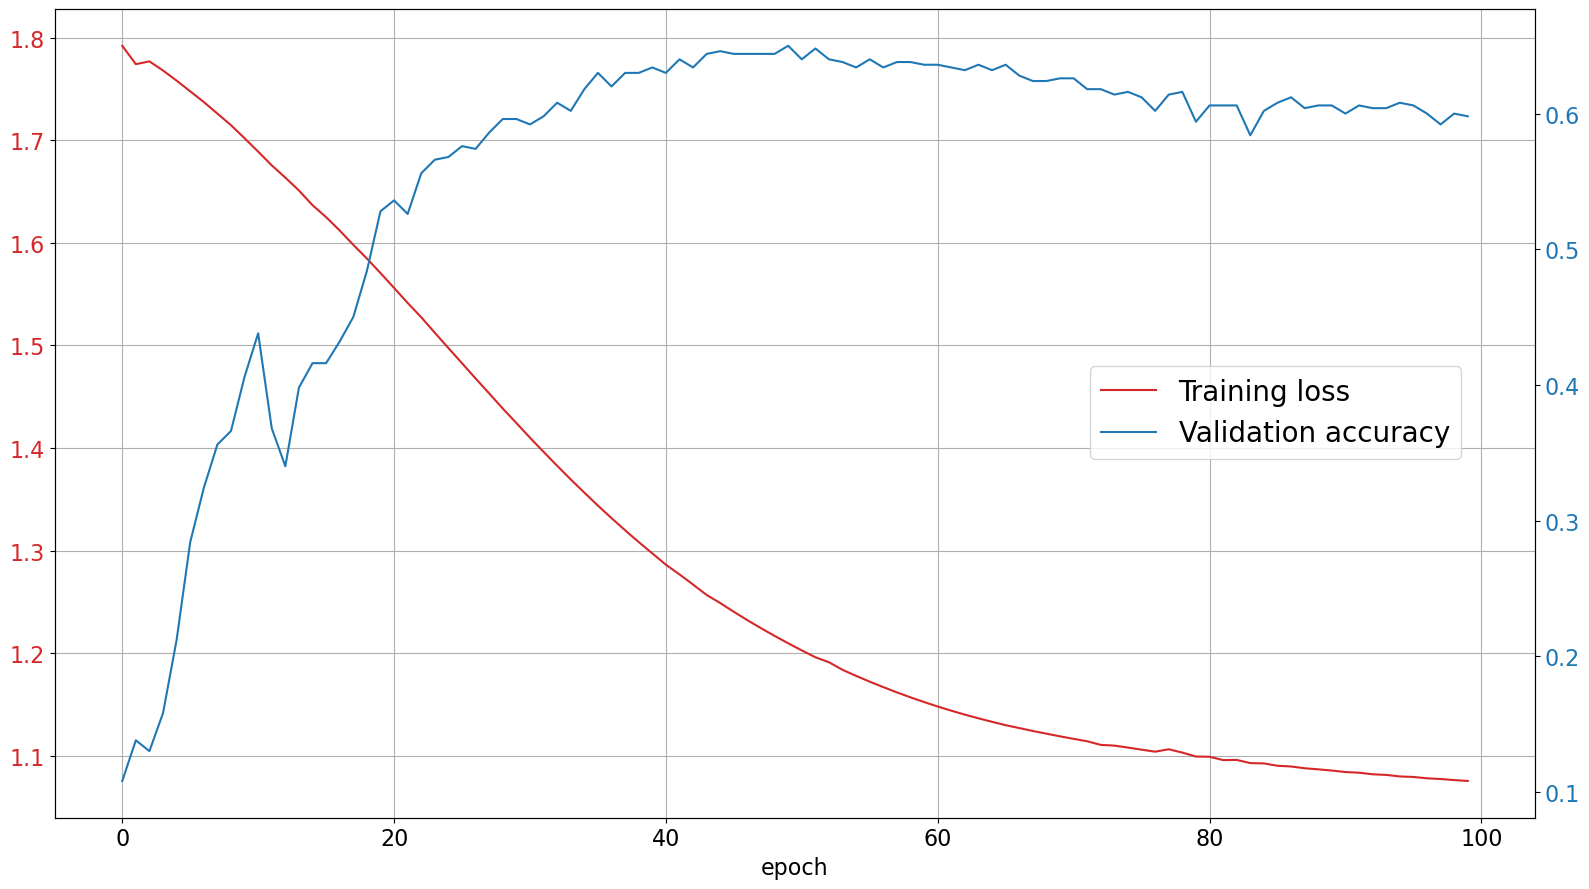

In [98]:
fig, ax = plt.subplots(figsize=(16, 9))

color = 'tab:red'
ax.plot(np.arange(epochs), training_loss, color=color, label='Training loss')
ax.tick_params(axis='y', labelcolor=color, labelsize=16)

color = 'tab:blue'
right_y = ax.twinx()
right_y.plot(np.arange(epochs), validation_accuracy, color=color, label='Validation accuracy')
right_y.tick_params(axis='y', labelcolor=color, labelsize=16)

ax.set_xlabel('epoch', fontsize=16)
ax.tick_params(axis='x', labelsize=16)

fig.tight_layout()
ax.grid(True)
fig.legend(loc='center right', fontsize=20, bbox_to_anchor=(0.925, 0.535))
plt.show()

In [99]:
inputs, labels = data.x, data.y[data.test_mask]

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # Calculate outputs by running embeddings through the network
    outputs = net(inputs, norm_adj_mat)[data.test_mask]

# The class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs.data, 1)
total = labels.size(0)
correct = (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy in the test set: {100 * accuracy:.2f}%')

Accuracy in the test set: 59.30%


In [100]:
from torchmetrics import AUROC

In [101]:
auc = AUROC(task="multiclass", num_classes=6)
roc = auc(outputs.data,labels.data)
print(roc)

tensor(0.8224)
